#Environment configuration

Install packages.

In [ ]:
#Don't run this code unless you really want to install the packages.
#!pip install mediapipe --quiet
#!pip install tqdm --quiet

     |████████████████████████████████| 32.8 MB 1.3 MB/s 


Import packages.

In [ ]:
import pandas as pd
import os
import cv2 as cv
import mediapipe as mp
import numpy as np
import re
import shutil

from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tqdm.auto import tqdm
from tabulate import tabulate
from google.colab import drive
from random import randint 

Mount and config GDrive & paths.

In [ ]:
drive.mount('/content/drive')
gdrive = '/content/drive/My Drive/ml_projects/STRHANGE/'
labels_path = gdrive + '/data/JESTER/labels/'
keypoints_path = gdrive + '/data/JESTER/extracted/'
target_path = gdrive + '/data/JESTER/final/'
data_path = '/content/data/20bn-jester-v1/'
landmark_path =  '/content/landmarks/'

Mounted at /content/drive


#### Load and extract zipped image-package *JESTER* into local environment. 

This speeds up access to the data files in the subsequent processing steps significantly.

In [ ]:
cp -R /content/drive/MyDrive/ml_projects/STRHANGE/data/JESTER/unzipped_split /content/data

In [ ]:
cd /content/data

/content/data


In [ ]:
cat 20bn-jester-v1-?? | tar zx

Image sequences are extracted and stored in the local folder */content/data/20bn-jester-v1*, accessable via the variable *data_path*.

In [ ]:
print(f'Number of image sequences: {len(os.listdir(data_path))}')

Number of image sequences: 148092


Size of Data folder:

In [ ]:
! du -sh /content/data/20bn-jester-v1

37G	/content/data/20bn-jester-v1


#### Load labels associated with the image sequences.

In [ ]:
os.listdir(labels_path)

['train.csv', 'validation.csv', 'test.csv', 'labels.csv', 'test-answers.csv']

The datasets comes with a pre-defined train-, validation- and test-split. However, since we will split the dataset differently (by classes, not by instances), we merge all label-tables together.

In [ ]:
labels = pd.read_csv(labels_path + 'labels.csv', sep = ';', header = None, names = ['label'])

train_labels = pd.read_csv(labels_path + 'train.csv', sep = ';', header = None, names = ['instance', 'label'])
val_labels = pd.read_csv(labels_path + 'validation.csv', sep = ';', header = None, names = ['instance', 'label'])
test_labels = pd.read_csv(labels_path + 'test-answers.csv', sep = ';', header = None, names = ['instance', 'label'])

all_data_labels = pd.concat([train_labels, val_labels, test_labels])

In [ ]:
print(f'Number of labels: {len(os.listdir(data_path))}')

Number of labels: 148092


Number of image sequences matches number of labels.

#### Create label map providing better mapping of label indexes to their names

All labels are mapped according the the original paper-labeling, excluding labels 0-3. This has no impact on the results, but was easier to code.

In [ ]:
label_map = {'No gesture': 0,
            'Doing other things': 1,
            'Drumming Fingers': 2,
            'Pulling Hand In': 3,
            'Pulling Two Fingers In': 4,
            'Pushing Hand Away': 5,
            'Pushing Two Fingers Away': 6,
            'Rolling Hand Backward': 7,
            'Rolling Hand Forward': 8,
            'Shaking Hand': 9,
            'Sliding Two Fingers Down': 10,
            'Sliding Two Fingers Left': 11,
            'Sliding Two Fingers Right': 12,
            'Sliding Two Fingers Up': 13,
            'Stop Sign': 14,
            'Swiping Down': 15,
            'Swiping Left': 16,
            'Swiping Right': 17,
            'Swiping Up': 18,
            'Thumb Down': 19,
            'Thumb Up': 20,
            'Turning Hand Clockwise': 21,
            'Turning Hand Counterclockwise': 22,
            'Zooming In With Full Hand': 23,
            'Zooming In With Two Fingers': 24,
            'Zooming Out With Full Hand': 25,
            'Zooming Out With Two Fingers': 26}

# Data analysis #1 - *pre keypoint extraction*

#### Plot classes in the dataset and their number of representations

In [ ]:
#Count unique values in the label-table
value_counts = all_data_labels.label.value_counts()

#Assign the values to their key in the label map
value_counts_ordered = []
for key in label_map:
  value_counts_ordered.append([key, value_counts[key]])

#Create a dataframe for easy plotting
value_counts_ordered = pd.DataFrame(value_counts_ordered, columns = ('labels', 'label_counts'))

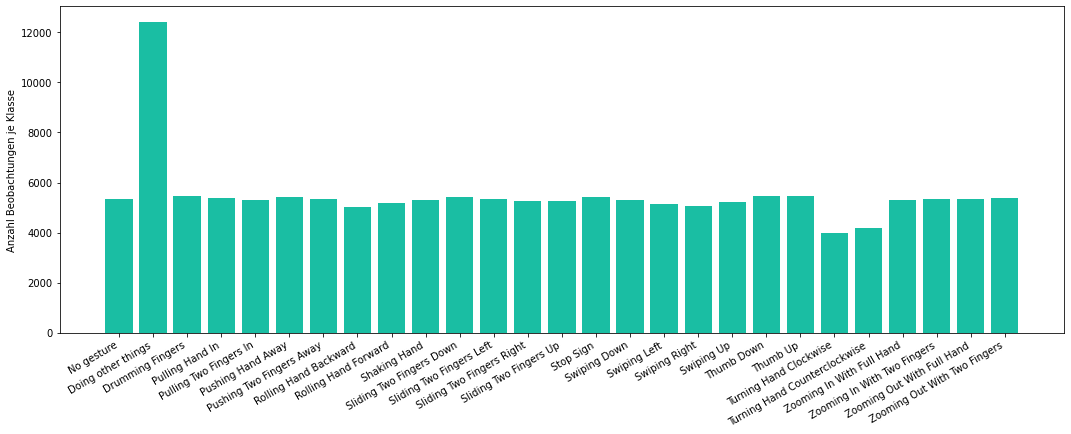

In [ ]:
#Plot classes and their number of representations

plt.figure(figsize=(18,6))

plt.bar(x = value_counts_ordered.labels, height = value_counts_ordered.label_counts, color = '#1ABEA3')

plt.xticks(rotation=30, horizontalalignment='right')
plt.ylabel('Anzahl Beobachtungen je Klasse')
#plt.title('Überblick über die Klassen', fontsize = 14)

plt.show()

#### Show a few example images

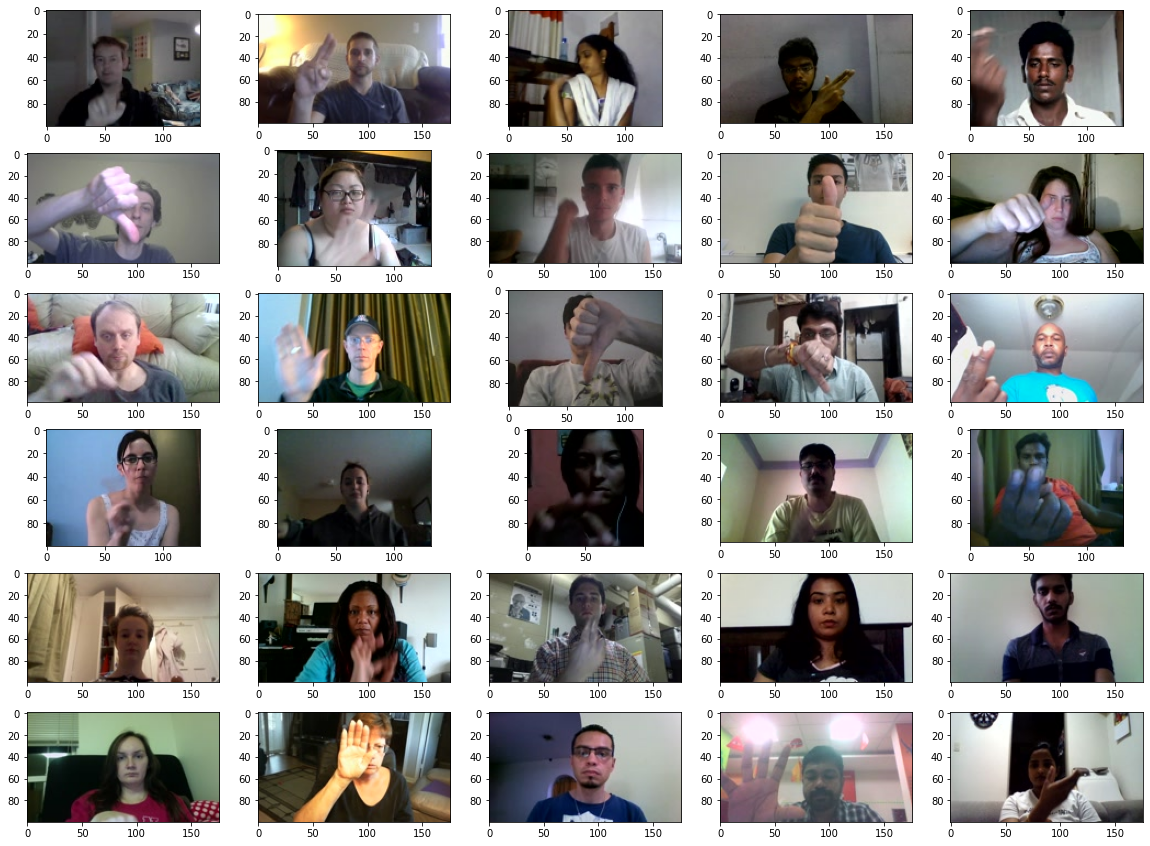

In [ ]:
#Config the figure
plt.figure(figsize=(20,15))
num_images = 30

#Take a sample of all the samples
sample_instances = all_data_labels.sample(num_images).instance

#Iterate over all sampled instances, grab a sample frame and plot it
for i, instance in enumerate(sample_instances):
  img_paths = os.listdir(os.path.join(data_path, str(sample_instances.iloc[i])))
  img_i = np.random.randint(len(img_paths))
  img_path = os.path.join(data_path, str(sample_instances.iloc[i]), img_paths[img_i])

  plt.subplot(6,5,i+1)
  img = cv.imread(img_path)
  img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
  plt.imshow(img)

In [ ]:
def plot_random_gesture():
  """
  Visualization of an random instance. (Only the middle part, to show less clutter)
  """
  #Config the figure
  plt.figure(figsize=(20,7))

  #Grab sample and config start to end_frame
  sample_instances = all_data_labels.sample(1)['instance'].iloc[0]
  num_images = len(os.listdir(os.path.join(data_path, str(sample_instances))))
  mid_images = int(num_images/2)
  start_image = mid_images - 7
  end_image = mid_images + 8

  #plot sequence
  place = 1
  for i in range(start_image, end_image):
    img_path = os.path.join(data_path, str(sample_instances), f'{str(i).zfill(5)}.jpg')
    plt.subplot(3,5,place)
    img = cv.imread(img_path)
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    plt.imshow(img)
    place += 1

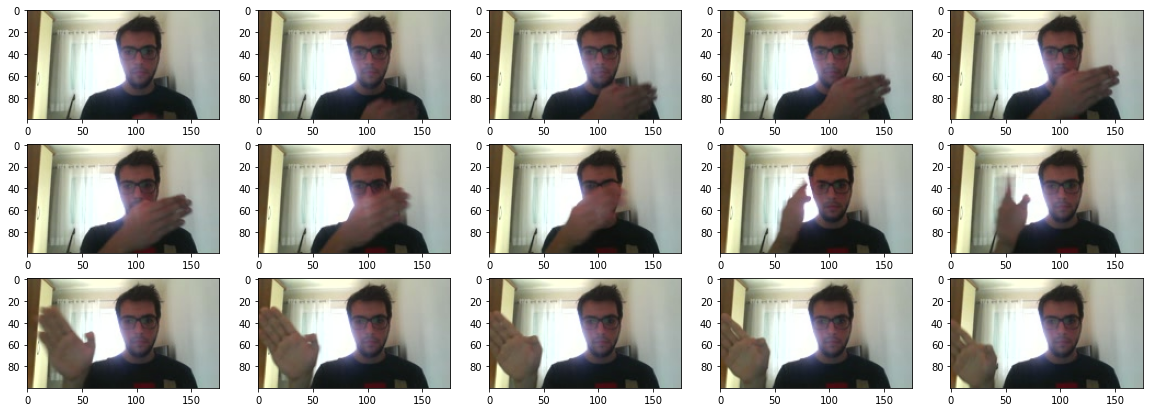

In [ ]:
plot_random_gesture()

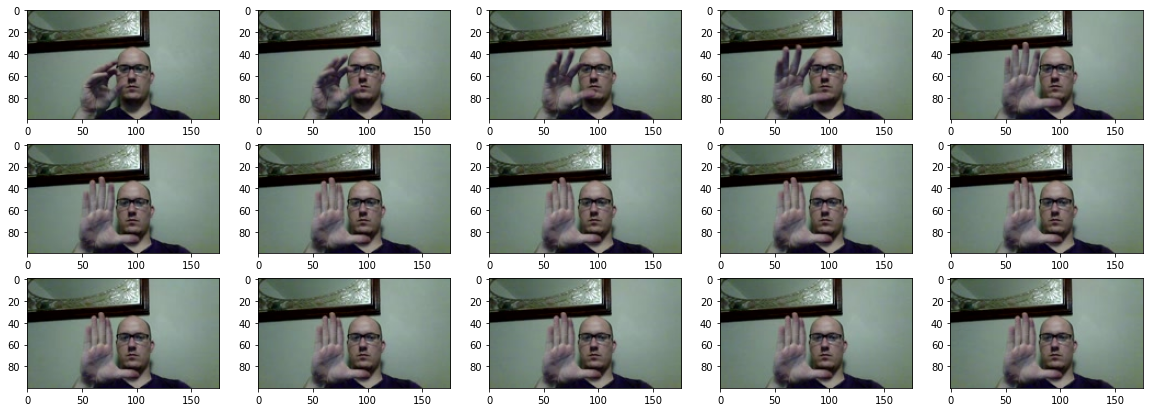

In [ ]:
plot_random_gesture()

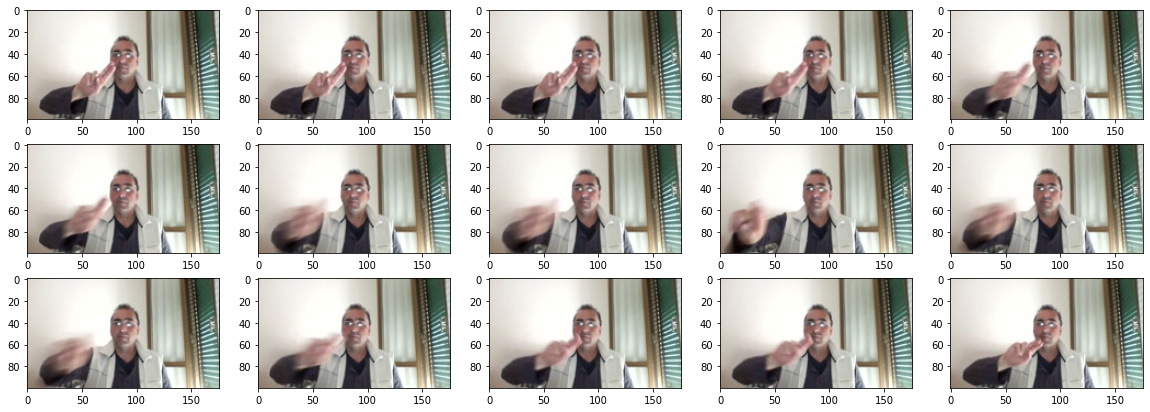

In [ ]:
plot_random_gesture()

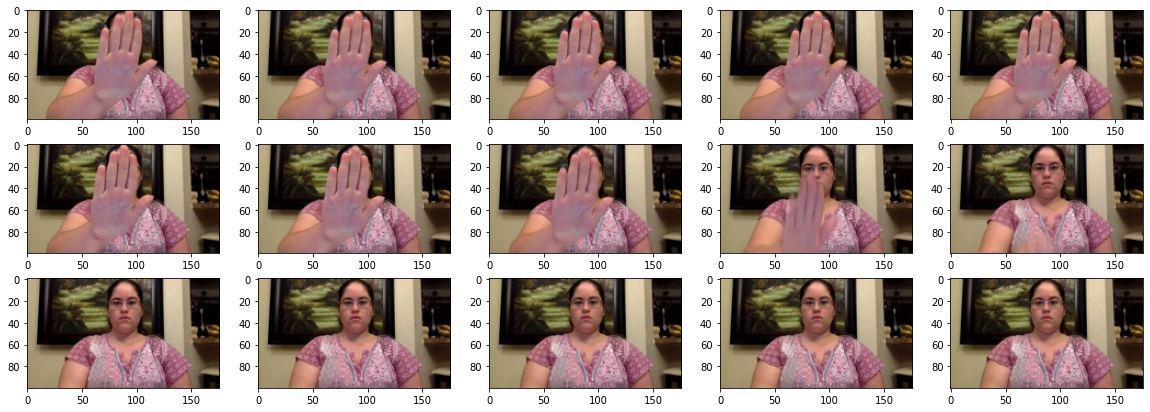

In [ ]:
plot_random_gesture()

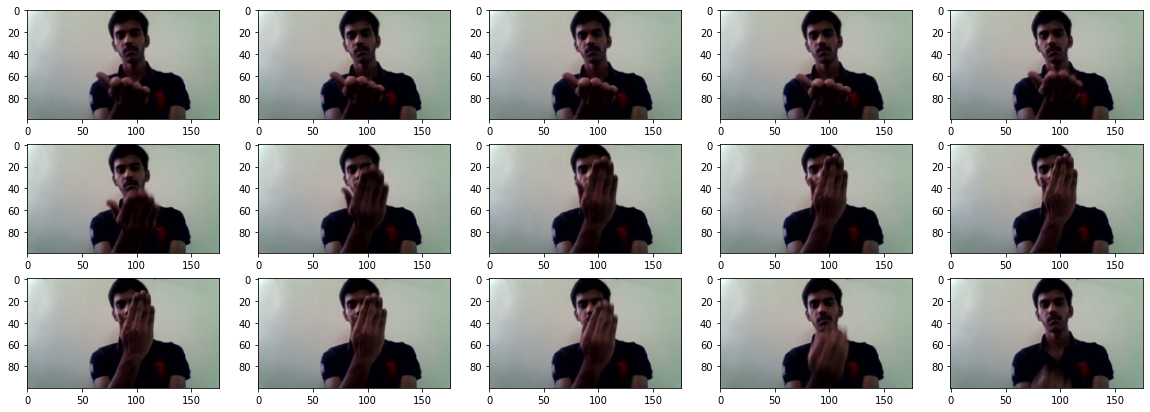

In [ ]:
plot_random_gesture()

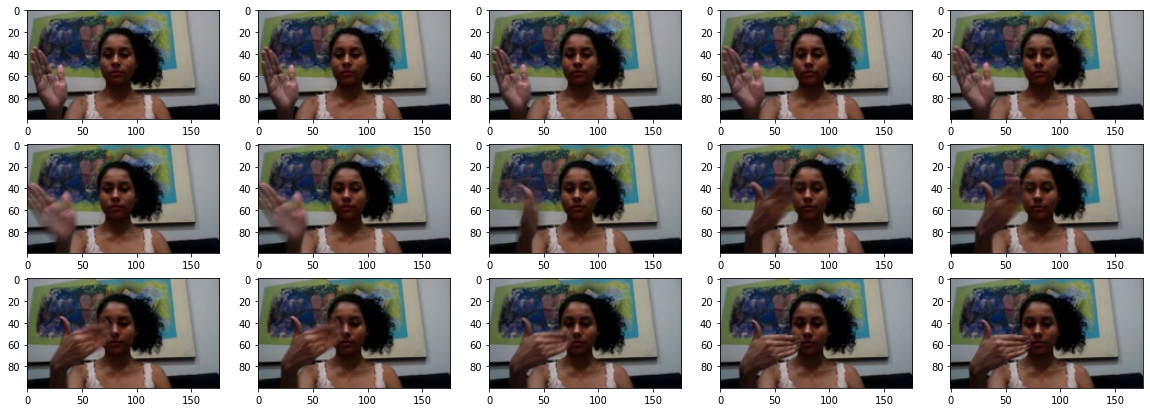

In [ ]:
plot_random_gesture()

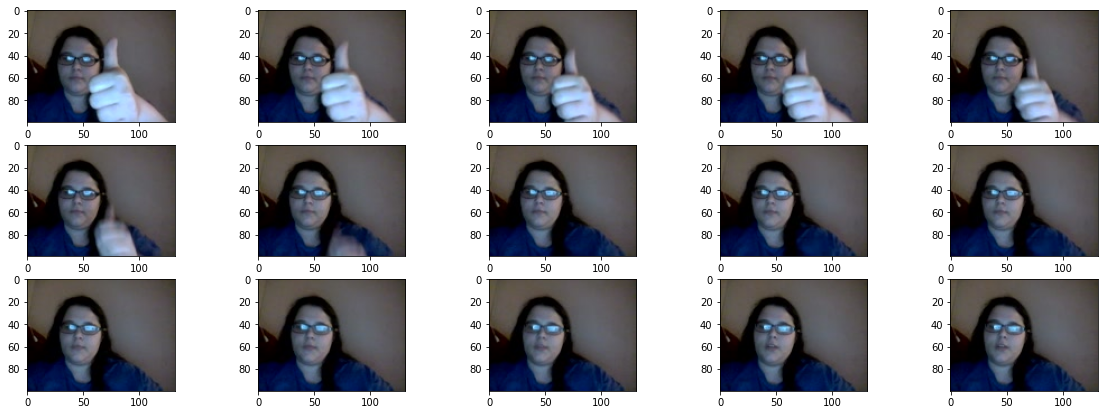

In [ ]:
plot_random_gesture()

We can observe a high variety of hand positions, exposures, proximity to the camera and physical characteristics of the participants. Furthermore, we note that many images do not contain a hand. Every image has the same height, but a different width.

#### Plot frames per instance

In [ ]:
# Get all the instances-paths 
instances = os.listdir(data_path)

# Loop over the instances-paths and count the number of pictures / frames in each instance
imgs_in_sequence = []
for img_seq in instances:
  imgs_in_sequence.append(len(os.listdir(os.path.join(data_path, img_seq))))

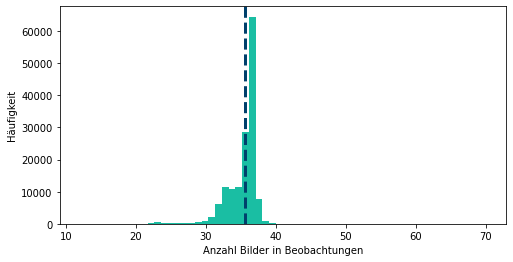

Average: 35.65068335899306
Min: 12
Max: 70


In [ ]:
# Plot the number of frames per instance

plt.figure(figsize=(8,4))

plt.hist(x = imgs_in_sequence, color = '#1ABEA3', bins = 60)
plt.axvline(np.mean(imgs_in_sequence), color='#00406C', linestyle='dashed', linewidth=3)

plt.ylabel('Häufigkeit')
plt.xlabel('Anzahl Bilder in Beobachtungen')
#plt.title('Verteilung der Anzahl von Bildern pro Beobachtung', fontsize = 14)
plt.show()

print(f'Average: {np.mean(imgs_in_sequence)}')
print(f'Min: {np.min(imgs_in_sequence)}')
print(f'Max: {np.max(imgs_in_sequence)}')

# Hand Skeleton Keypoint Extraction

Our Few Shot Learning model will make its prediction based on hand skeleton keypoints alone. These points are extracted with the help of Google's [Mediapipe](https://google.github.io/mediapipe/solutions/hands.html) library, which extracts 21 Keypoints for every hand in 3 dimensions x, y and z.

![Mediapipe](https://google.github.io/mediapipe/images/mobile/hand_tracking_3d_android_gpu.gif)

Source: [Mediapipe](https://google.github.io/mediapipe/solutions/hands.html)

## Preparation steps

First, we take a sample of the dataset, since the total number of 148092 instances can not be handled by the RAM of the google colab machines. Resulting number of instances (80.000) is still more than enough for the following process.

In [ ]:
#Take the sample of the labels and reset index
data_labels = all_data_labels.sample(80000)
data_labels.reset_index(drop = True, inplace = True)

Extracting the keypoints of 80.000 instances/sequences with around 35 pictures each takes many resources and hours. Therefore, this task is split into 8 batches, which will be merged after the execution of the keypoint extraction. 

In [ ]:
#Define number of batches and batch size
num_batches = 8
batch_size = int(data_labels.shape[0] / num_batches)

#Assign batch_indexes (batch runs) to the labels and append it to the data_labels table
batch_indexes = []
for batch in range(num_batches):
  batch_indexes.append([batch] * batch_size)

batch_indexes = np.array(batch_indexes).reshape(batch_size * num_batches)

data_labels['batch_index'] = batch_indexes

*data_labels* is the config-table, which tells each batch-run which data it has to process. To make it available to other notebooks, it will be uploaded to GDrive.

In [ ]:
data_labels.to_pickle(os.path.join(gdrive, '/data/JESTER/extraction_config/data_labels_incl_batch_index.pkl'))

## Create helper functions needed for the feature extraction.

In [ ]:
def get_no_of_frames(df, data_path):
  """
  Picks random sample of size n_support+n_querry, for n_way classes
  Args:
    df (dataframe): dataframe with column 'instance' which indicates the name of each data instance
    data_path (str): path to the instances
  Returns:
    frames_per_subfolder (list): number of frames in each instance
  """
  frames_per_subfolder = []

  #Loop over every instance in column 'instance'
  for s in df.instance:
    # if instance exists in 'data_path', count the number of frames, else return 0
    if os.path.isdir(os.path.join(data_path, str(s))):
      frames_per_subfolder.append([str(s),len(os.listdir(os.path.join(data_path, str(s))))])
    else:
      frames_per_subfolder.append([str(s), 0])
  return frames_per_subfolder

In [ ]:
def detect_hand(image_path):
  """
  Runs the standard mediapipe-hand-detection model on a single image
  Args:
    image_path (str): path to an image
  Returns:
    result (mp-hands-object): result of a mediapipe-Hands hand-detection
  """
  #Run the mp_hands.Hands-Model with standard-Params (one Hand max, min_confidence of 0.5) on a flipped image (because webcam images are flipped aswell)
  with mp_hands.Hands(
      static_image_mode = True,
      max_num_hands = 1,
      min_detection_confidence = 0.5) as hands:
      image = cv.flip(cv.imread(image_path), 1)
      result = hands.process(cv.cvtColor(image, cv.COLOR_BGR2RGB))
  return result

In [ ]:
def extract_keypoints(results):
  """
  Extracts keypoints from a given mediapipe-Hands-result
  Args:
    results (mp-hands-object): result of a mediapipe-Hands hand-detection
  Returns:
    keypoints (np array): 63 keypoints + hand-indicator + classification-score or 65 zeros
  """
  # If the detection was succesfull, return 63 keypoints + hand-indicator and classification-score, else return 65 zeros
  if results.multi_hand_landmarks:
    detection = np.array([0 if results.multi_handedness[0].classification[0].label == 'Left' else 1,
                         results.multi_handedness[0].classification[0].score]).flatten() 
    landmarks = np.array([[res.x, res.y, res.z] for res in results.multi_hand_landmarks[0].landmark ]).flatten() if results.multi_hand_landmarks else np.zeros(63)
    return np.concatenate([detection, landmarks]) 
  else:
    return np.zeros(65)

In [ ]:
def generate_keypoint_data(df, data_path, target_path):
  """
  Runs the keypoint-extraction a given times and saves the extractions to a target_path as np.arrays
  Args:
    df (dataframe): config dataframe with columsn label and instance
    data_path (str): path to the instances
    target_path (str): path where the keypoints get saved to
  """
  #Loop over every unique label (hand gesture) of the given config dataframe
  for label in df.label.unique():
    print(f'Current label: {label}')
    try:
      os.makedirs(os.path.join(target_path, label))
    except:
      pass
    #Loop over every instance in this label
    for i in tqdm(df.instance[df.label == label]):
      if os.path.isdir(os.path.join(data_path, str(i))):
        try: 
          os.makedirs(os.path.join(target_path, label, str(i)))
        except:
          pass
        #Loop over every image/frame of this instance, run the mp.hands-model, extract the keypoints and save it as np.array
        for img in os.listdir(os.path.join(data_path, str(i))):
          hand = detect_hand(os.path.join(data_path, str(i), img))
          keypoints = extract_keypoints(hand)
          np.save(os.path.join(target_path, label, str(i), str(re.sub('.jpg', '', img))), keypoints)

In [ ]:
def extract_and_safe_keypoints_for_batch(batch, batch_start_index, max_frames_per_instance, label_map):
  """
  Main function for batch-based feature extraction. Generates keypoints from a given batch and uploads them to GDrive.
  Args:
    batch (int): Index of batch
    batch_start_index (int): index_start of the final data table
    max_frames_per_instance (int): maximum number of frames along the whole dataset
    label_map (map): map of label-indexes and their names
  """
  #Filter labels on batch
  batch_labels = data_labels[data_labels.batch_index == batch]

  #Generate keypoints for batch of data
  print('Extracting keypoints from sequences in batch.')
  generate_keypoint_data(batch_labels, data_path, landmark_path)

  #Gather all the keypoints from the temp np.arrays saved by 'generate_keypoint_data'
  print('Gathering keypoints to create X and y for batch.')

  sequences, labels = [], []
  i = batch_start_index
  batch_labels['data_index'] = batch_start_index

  for action in batch_labels.label.unique():
    for sequence in os.listdir(os.path.join(landmark_path, action)):
      window = []
      for frame_num in range(int(max_frames_per_instance)):
        if os.path.isfile(os.path.join(landmark_path, action, str(sequence), "{}.npy".format(str(frame_num+1).zfill(5)))):
          res = np.load(os.path.join(landmark_path, action, str(sequence), "{}.npy".format(str(frame_num+1).zfill(5))))
          window.append(res)
        else:
          window.append(np.zeros(65))
      batch_labels.loc[batch_labels['instance'] == int(sequence), 'data_index'] = i
      i += 1
      
      sequences.append(window)
      labels.append(label_map[action])

  X = np.array(sequences)
  y = to_categorical(labels).astype(int)

  print(f'Created X with shape {X.shape}')
  print(f'Created y with shape {y.shape}')

  # Upload X (keypoints), y (labels) and assignment_batch (dataframe which stores which X-data belong to which instance)
  print('Saving X, y, landmarks and the assignment-table to GDrive.')

  np.save(os.path.join(keypoints_path, f'X_{batch}'), X)
  np.save(os.path.join(keypoints_path, f'y_{batch}'), y)

  batch_labels.to_pickle(os.path.join(keypoints_path, f'assignment_batch_{batch}.pkl'))

  shutil.make_archive(keypoints_path + f'landmarks_{batch}', 'zip', '/content/landmarks')

  print('Save succesfull.')

## Execude batched keypoint extraction

Despite the following code provides only one example for batch #0, this step has been done 8 times, distributed on 4 machines.

In [ ]:
#Set mediapipe model
mp_hands = mp.solutions.hands

In [ ]:
#Load config-table
data_labels = pd.read_pickle(gdrive + '/data/JESTER/extraction_config/data_labels_incl_batch_index.pkl')

In [ ]:
rm -rf '/content/landmarks'

In [ ]:
#Get maximum number of frames in the overall dataset
no_of_frames = get_no_of_frames(data_labels, data_path)
max_frames_per_instance = max(np.array(no_of_frames)[:,1])

#Config batch run (this is batch run 0 out of 8)
batch = 0
batch_start_index = int(data_labels.shape[0] / num_batches) * batch

#Check label map
label_map = {label:num for num, label in enumerate(data_labels.label.unique())}
print(label_map)

{'No gesture': 0, 'Doing other things': 1, 'Pulling Two Fingers In': 2, 'Pushing Two Fingers Away': 3, 'Zooming In With Two Fingers': 4, 'Pulling Hand In': 5, 'Swiping Down': 6, 'Drumming Fingers': 7, 'Sliding Two Fingers Down': 8, 'Sliding Two Fingers Right': 9, 'Swiping Up': 10, 'Sliding Two Fingers Left': 11, 'Zooming Out With Two Fingers': 12, 'Stop Sign': 13, 'Swiping Left': 14, 'Shaking Hand': 15, 'Zooming In With Full Hand': 16, 'Sliding Two Fingers Up': 17, 'Turning Hand Counterclockwise': 18, 'Thumb Up': 19, 'Rolling Hand Backward': 20, 'Pushing Hand Away': 21, 'Swiping Right': 22, 'Rolling Hand Forward': 23, 'Thumb Down': 24, 'Turning Hand Clockwise': 25, 'Zooming Out With Full Hand': 26}


In [ ]:
# Run extraction for batch 
extract_and_safe_keypoints_for_batch(batch, batch_start_index, max_frames_per_instance, label_map)

Extracting keypoints from sequences in batch.
Current label: No gesture


  0%|          | 0/397 [00:00<?, ?it/s]

Current label: Doing other things


  0%|          | 0/776 [00:00<?, ?it/s]

Current label: Pulling Two Fingers In


  0%|          | 0/357 [00:00<?, ?it/s]

Current label: Pushing Two Fingers Away


  0%|          | 0/375 [00:00<?, ?it/s]

Current label: Zooming In With Two Fingers


  0%|          | 0/359 [00:00<?, ?it/s]

Current label: Pulling Hand In


  0%|          | 0/369 [00:00<?, ?it/s]

Current label: Swiping Down


  0%|          | 0/339 [00:00<?, ?it/s]

Current label: Drumming Fingers


  0%|          | 0/362 [00:00<?, ?it/s]

Current label: Sliding Two Fingers Down


  0%|          | 0/361 [00:00<?, ?it/s]

Current label: Sliding Two Fingers Right


  0%|          | 0/341 [00:00<?, ?it/s]

Current label: Swiping Up


  0%|          | 0/339 [00:00<?, ?it/s]

Current label: Sliding Two Fingers Left


  0%|          | 0/351 [00:00<?, ?it/s]

Current label: Zooming Out With Two Fingers


  0%|          | 0/354 [00:00<?, ?it/s]

Current label: Stop Sign


  0%|          | 0/385 [00:00<?, ?it/s]

Current label: Swiping Left


  0%|          | 0/377 [00:00<?, ?it/s]

Current label: Shaking Hand


  0%|          | 0/345 [00:00<?, ?it/s]

Current label: Zooming In With Full Hand


  0%|          | 0/345 [00:00<?, ?it/s]

Current label: Sliding Two Fingers Up


  0%|          | 0/373 [00:00<?, ?it/s]

Current label: Turning Hand Counterclockwise


  0%|          | 0/270 [00:00<?, ?it/s]

Current label: Thumb Up


  0%|          | 0/385 [00:00<?, ?it/s]

Current label: Rolling Hand Backward


  0%|          | 0/341 [00:00<?, ?it/s]

Current label: Pushing Hand Away


  0%|          | 0/391 [00:00<?, ?it/s]

Current label: Swiping Right


  0%|          | 0/358 [00:00<?, ?it/s]

Current label: Rolling Hand Forward


  0%|          | 0/349 [00:00<?, ?it/s]

Current label: Thumb Down


  0%|          | 0/350 [00:00<?, ?it/s]

Current label: Turning Hand Clockwise


  0%|          | 0/280 [00:00<?, ?it/s]

Current label: Zooming Out With Full Hand


  0%|          | 0/371 [00:00<?, ?it/s]

Gathering keypoints to create X and y for batch.
Created X with shape (10000, 67, 65)
Created y with shape (10000, 27)
Saving X, y, landmarks and the assignment-table to GDrive.
Save succesfull.


## Merge batch runs

After all 8 batches with 10000 instances each have been processed, they will be merged in the next step.

In [ ]:
num_batches = 8
X = []
y = []

#Loop over number of batches, load X (keypoints) and y (labels) from GDrive and merge the data
for batch in range(num_batches):
  if batch == 0:
    X = np.load(os.path.join(keypoints_path , f'X_{batch}.npy'))
    y = np.load(os.path.join(keypoints_path , f'y_{batch}.npy')) 
    assgnmt = pd.read_pickle(keypoints_path + f'assignment_batch_{batch}.pkl')
  if batch > 0:
    X_batch = np.load(os.path.join(keypoints_path , f'X_{batch}.npy'))
    y_batch = np.load(os.path.join(keypoints_path , f'y_{batch}.npy')) 
    assgnmt_batch = pd.read_pickle(keypoints_path + f'assignment_batch_{batch}.pkl')

    X = np.append(X, X_batch, axis=0)
    y = np.append(y, y_batch, axis=0)
    assgnmt = pd.concat([assgnmt, assgnmt_batch], axis=0)

X = X[:, :, 2:]
y = np.argmax(y, axis=1)

print(f'Shape of array X: {X.shape}')
print(f'Shape of array y: {y.shape}')
print(f'Shape of dataframe assignment: {assgnmt.shape}')

#Upload merged data to GDrive
np.save(os.path.join(keypoints_path, 'X_batches_merged.npy'), X)
np.save(os.path.join(keypoints_path, 'y_batches_merged.npy'), y)
assgnmt.to_pickle(os.path.join(keypoints_path, 'assignment_batches_merged.pkl'))

print(f'\nAll three objects uploaded to {keypoints_path}')

Shape of array X: (80000, 67, 63)
Shape of array y: (80000,)
Shape of dataframe assignment: (80000, 4)

All three objects uploaded to /content/drive/My Drive/ml_projects/STRHANGE//data/JESTER/extracted/


The label map got mixed up a bit in the keypoint-extraction process. Therefore, its gets fixed.

In [ ]:
y = np.load(os.path.join(keypoints_path , 'y_batches_merged.npy')) 

unique, counts = np.unique(y, return_counts=True)
print(tabulate(np.asarray((unique, counts))))

----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----
   0     1     2     3     4     5     6     7     8     9    10    11    12    13    14    15    16    17    18    19    20    21    22    23    24    25    26
2913  6716  2820  2875  2922  2923  2780  2942  2925  2818  2836  2857  2839  2888  2842  2870  2868  2872  2296  2974  2698  3044  2723  2790  2941  2123  2905
----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----


In [ ]:
correct_label_map = {'No gesture': 0,'Doing other things': 1,'Drumming Fingers': 2,'Pulling Hand In': 3,'Pulling Two Fingers In': 4,'Pushing Hand Away': 5,'Pushing Two Fingers Away': 6,
                    'Rolling Hand Backward': 7,'Rolling Hand Forward': 8,'Shaking Hand': 9,'Sliding Two Fingers Down': 10,'Sliding Two Fingers Left': 11,'Sliding Two Fingers Right': 12,
                    'Sliding Two Fingers Up': 13,'Stop Sign': 14,'Swiping Down': 15,'Swiping Left': 16,'Swiping Right': 17,'Swiping Up': 18,'Thumb Down': 19,'Thumb Up': 20,'Turning Hand Clockwise': 21,
                    'Turning Hand Counterclockwise': 22,'Zooming In With Full Hand': 23,'Zooming In With Two Fingers': 24,'Zooming Out With Full Hand': 25,'Zooming Out With Two Fingers': 26}

data_labels = pd.read_pickle(gdrive + '/data/JESTER/extraction_config/data_labels_incl_batch_index.pkl')
incorrect_label_map = {label:num for num, label in enumerate(data_labels.label.unique())}

print(incorrect_label_map)

{'No gesture': 0, 'Doing other things': 1, 'Pulling Two Fingers In': 2, 'Pushing Two Fingers Away': 3, 'Zooming In With Two Fingers': 4, 'Pulling Hand In': 5, 'Swiping Down': 6, 'Drumming Fingers': 7, 'Sliding Two Fingers Down': 8, 'Sliding Two Fingers Right': 9, 'Swiping Up': 10, 'Sliding Two Fingers Left': 11, 'Zooming Out With Two Fingers': 12, 'Stop Sign': 13, 'Swiping Left': 14, 'Shaking Hand': 15, 'Zooming In With Full Hand': 16, 'Sliding Two Fingers Up': 17, 'Turning Hand Counterclockwise': 18, 'Thumb Up': 19, 'Rolling Hand Backward': 20, 'Pushing Hand Away': 21, 'Swiping Right': 22, 'Rolling Hand Forward': 23, 'Thumb Down': 24, 'Turning Hand Clockwise': 25, 'Zooming Out With Full Hand': 26}


In [ ]:
#Exchange every "wrong"-label with a "correct"-label
y = pd.DataFrame(y)
for i in incorrect_label_map.values():
  label = [k for (k, v) in incorrect_label_map.items() if v == i]
  y[0].replace(i, label[0], inplace = True)

for i in correct_label_map.values():
  label = [k for (k, v) in correct_label_map.items() if v == i]
  y[0].replace(label[0], i, inplace = True)

y = y.to_numpy()
y = y.reshape(y.shape[0])

#Upload fixed labels to GDrive
np.save(os.path.join(keypoints_path, 'y_batches_merged.npy'), y)

#Check if fix was succesfull
unique, counts = np.unique(y, return_counts=True)
print(tabulate(np.asarray((unique, counts))))

----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----
   0     1     2     3     4     5     6     7     8     9    10    11    12    13    14    15    16    17    18    19    20    21    22    23    24    25    26
2913  6716  2942  2923  2820  3044  2875  2698  2790  2870  2925  2857  2818  2872  2888  2780  2842  2723  2836  2941  2974  2123  2296  2868  2922  2905  2839
----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----


# Data analysis #2 - *past keypoint extracting, pre feature engineering & cleaning*

#### Load merged data

In [ ]:
X = np.load(os.path.join(keypoints_path , 'X_batches_merged.npy'))
y = np.load(os.path.join(keypoints_path , 'y_batches_merged.npy')) 
assgnmt = pd.read_pickle(keypoints_path + 'assignment_batches_merged.pkl')

#### Plot classes in the dataset and their number of representations

In [ ]:
#Count unique values in the label-table
value_counts = np.array(np.unique(y, return_counts=True))

#Assign the values to their key in the label map
value_counts_ordered = []
for key in label_map:
  value_counts_ordered.append([f'index {str(label_map[key])}: {key}' , value_counts[1][label_map[key]]])

#Create a dataframe for easy plotting
value_counts_ordered = pd.DataFrame(value_counts_ordered, columns = ('labels', 'label_counts'))

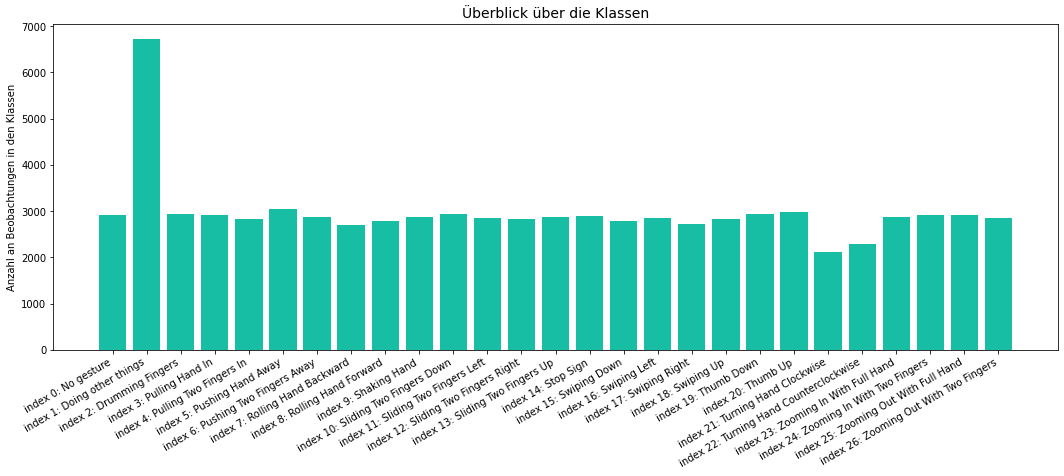

In [ ]:
#Plot classes and their number of representations
plt.figure(figsize=(18,6))

plt.bar(x = value_counts_ordered.labels, height = value_counts_ordered.label_counts, color = '#17BEA3')
plt.xticks(rotation=30, horizontalalignment='right')
plt.ylabel('Anzahl an Beobachtungen in den Klassen')
plt.title('Überblick über die Klassen', fontsize = 14)
plt.show()

#### Plot the length of gestures performed, measured in frames

By analysing the length of the first index where a keypoint occurs in a sequence until the last index where a keypoint occurs, we can see how long the gestures are actively performed.

In [ ]:
gesture_length = []

#Loop over all keypoint-instances, find the index of the first and last keypoint and form the distance between both indexes
for i in range(len(X)):
  means = X[i].mean(axis = 1)
  if means.max() != 0:
    start_frame = next(i for i,v in enumerate(means) if v != 0)
    end_frame = next(i for i,v in reversed(list(enumerate(means))) if v != 0)
    gesture_length.append(end_frame - start_frame)
  else: 
    gesture_length.append(0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


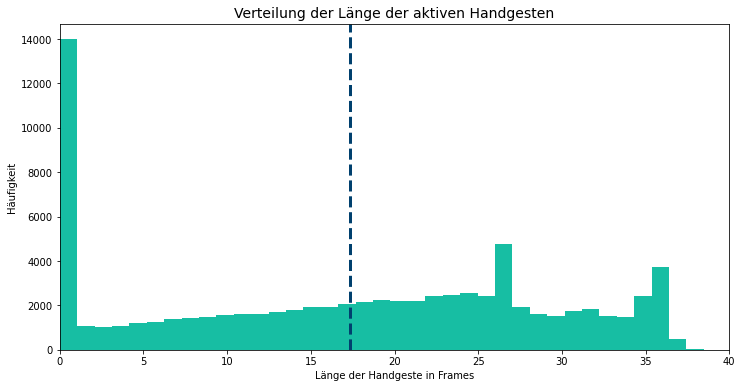

Average: 17.3149875


In [ ]:
#Plot length of active gestures in frames
plt.figure(figsize=(12,6))

plt.hist(x = gesture_length, color = '#17BEA3', bins = 50, )
plt.axvline(np.mean(gesture_length), color='#00406E', linestyle='dashed', linewidth=3)

axes = plt.axes()
axes.set_xlim([0, 40])
plt.ylabel('Häufigkeit')
plt.xlabel('Länge der Handgeste in Frames')
plt.title('Verteilung der Länge der aktiven Handgesten', fontsize = 14)
plt.show()

print(f'Average: {np.mean(gesture_length)}')

#### Visualize instances and their keypoints

Mediapipe allows us to print the keypoints and its interconnections on images. To get a better feeling of how well our extraction worked, we will analyse some examples.

In [ ]:
def plot_gesture_incl_keypoints(x_index, fig_width = 20, fig_height = 60, imgs_in_row = 5):
  """
  Visualization of an instance and its extracted keypoints.
  Args:
    x_index (int): Index of the instance to be plotted
    fig_width (int): width of the figure
    fig_height (int): height of the figure
    imgs_in_row (int): maximum imgs in a row
  """

  #Config mp-hands
  mp_drawing = mp.solutions.drawing_utils
  mp_drawing_styles = mp.solutions.drawing_styles
  mp_hands = mp.solutions.hands

  #Set image-path
  imgs_path = os.path.join(data_path, str(assgnmt[assgnmt.data_index==x_index]['instance'].values[0]))

  #Create figure
  plt.figure(figsize=(fig_width,fig_height))

  #Loop over every image of the instance
  for i in range(1, len(os.listdir(imgs_path))):
    img_path = os.path.join(imgs_path, f'{str(i).zfill(5)}.jpg')

    #generate an multi_hand_landmarks-Object
    with mp_hands.Hands(
        static_image_mode = True,
        max_num_hands = 1,
        min_detection_confidence = 0.0) as hands:
        image = cv.flip(cv.imread(img_path), 1)
        results = hands.process(cv.cvtColor(image, cv.COLOR_BGR2RGB))
      
    plt.subplot(len(os.listdir(imgs_path)),imgs_in_row,i)

    img = cv.flip(cv.imread(img_path), 1)
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)

    landmarks_X = X[x_index][i]

    #overwrite its value with out previously extracted keypoints
    if results.multi_hand_landmarks:
      if landmarks_X[0] == 0:
        results.multi_handedness[0].classification[0].label == 'Left'
      elif landmarks_X[0] == 1:
        results.multi_handedness[0].classification[0].label == 'Right'

      lm_i_x, lm_i_y, lm_i_z = 0, 1, 2

      for res_i in range(21):
        
        results.multi_hand_landmarks[0].landmark[res_i].x = landmarks_X[lm_i_x]
        results.multi_hand_landmarks[0].landmark[res_i].y = landmarks_X[lm_i_y]
        results.multi_hand_landmarks[0].landmark[res_i].z = landmarks_X[lm_i_z]

        lm_i_x += 3
        lm_i_y += 3
        lm_i_z += 3


    if results.multi_hand_landmarks:
      for num, hand in enumerate(results.multi_hand_landmarks):
        mp_drawing.draw_landmarks(img, hand, mp_hands.HAND_CONNECTIONS,
                                  mp_drawing.DrawingSpec(color=(0, 0, 0), thickness=1, circle_radius=1))

    #Plot the image
    plt.imshow(img)
    #plt.title(f'{str(i).zfill(5)}.jpg')
    plt.subplots_adjust(hspace = .4)

Plot random samples to envestigate mediapipes performance.

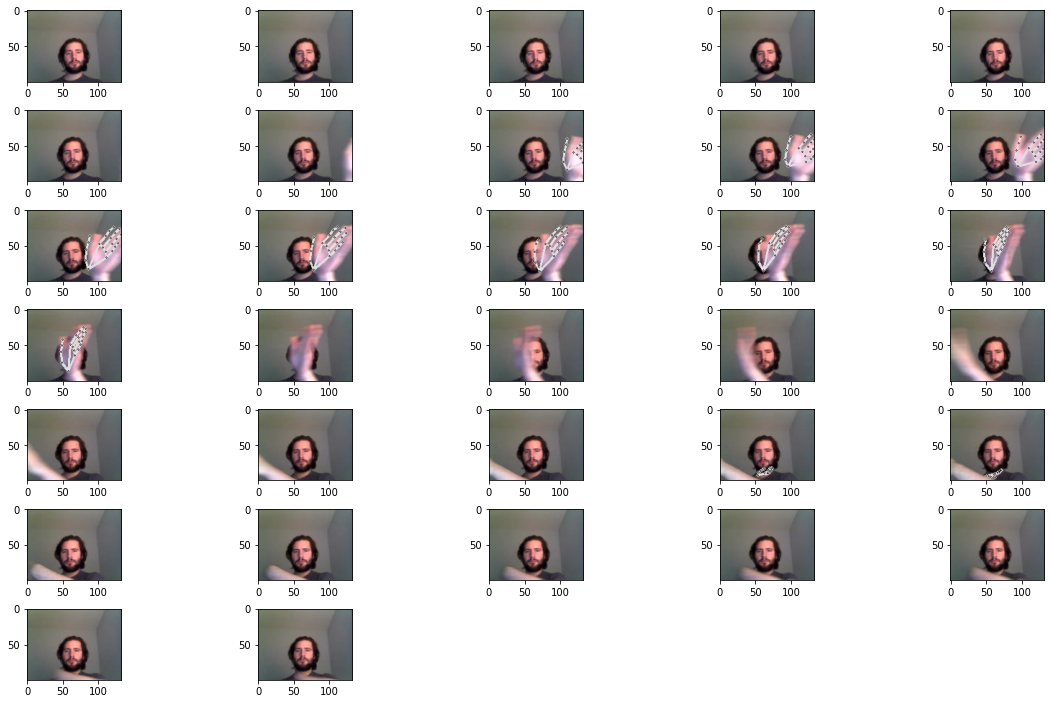

In [ ]:
plot_gesture_incl_keypoints(randint(0, X.shape[0])) 

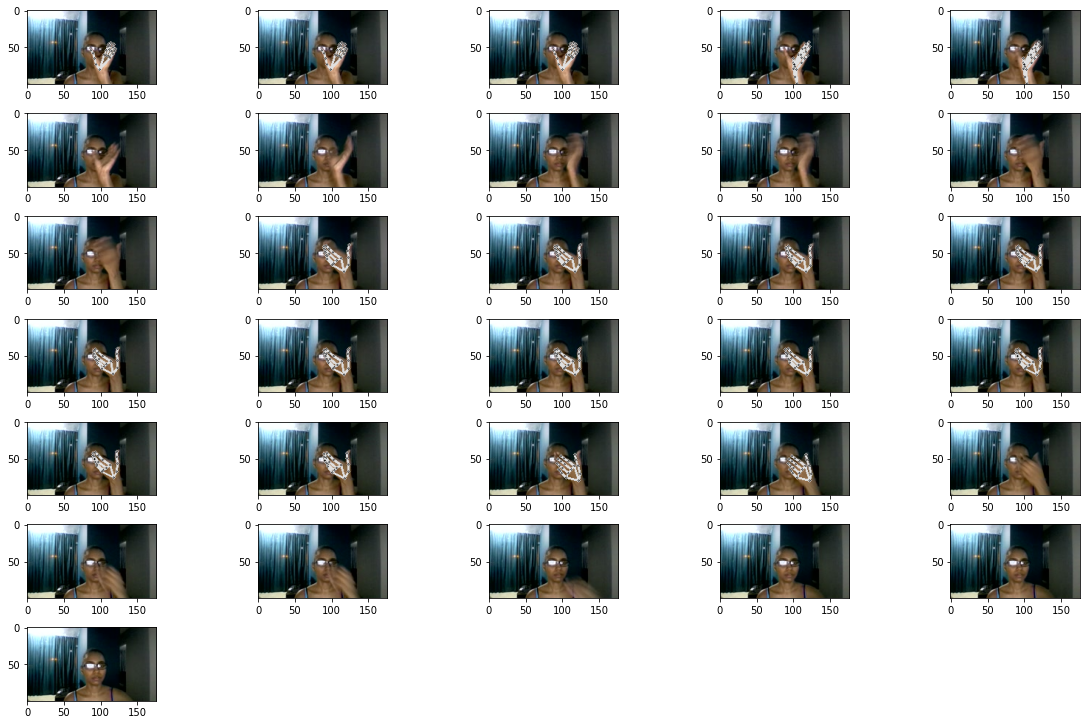

In [ ]:
plot_gesture_incl_keypoints(randint(0, X.shape[0]))

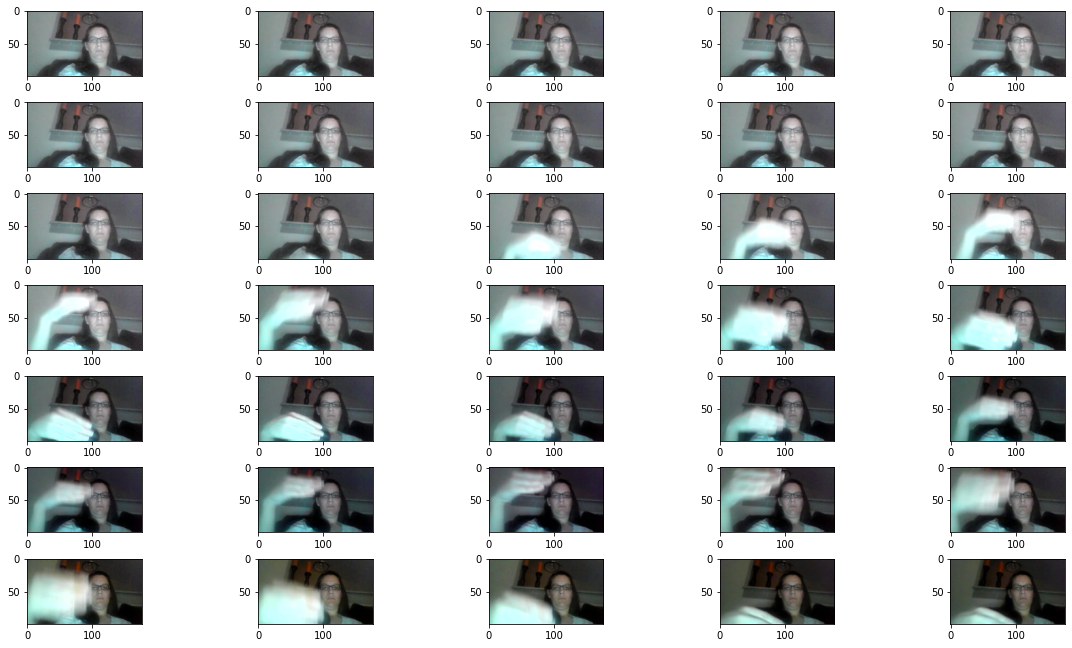

In [ ]:
plot_gesture_incl_keypoints(randint(0, X.shape[0]))

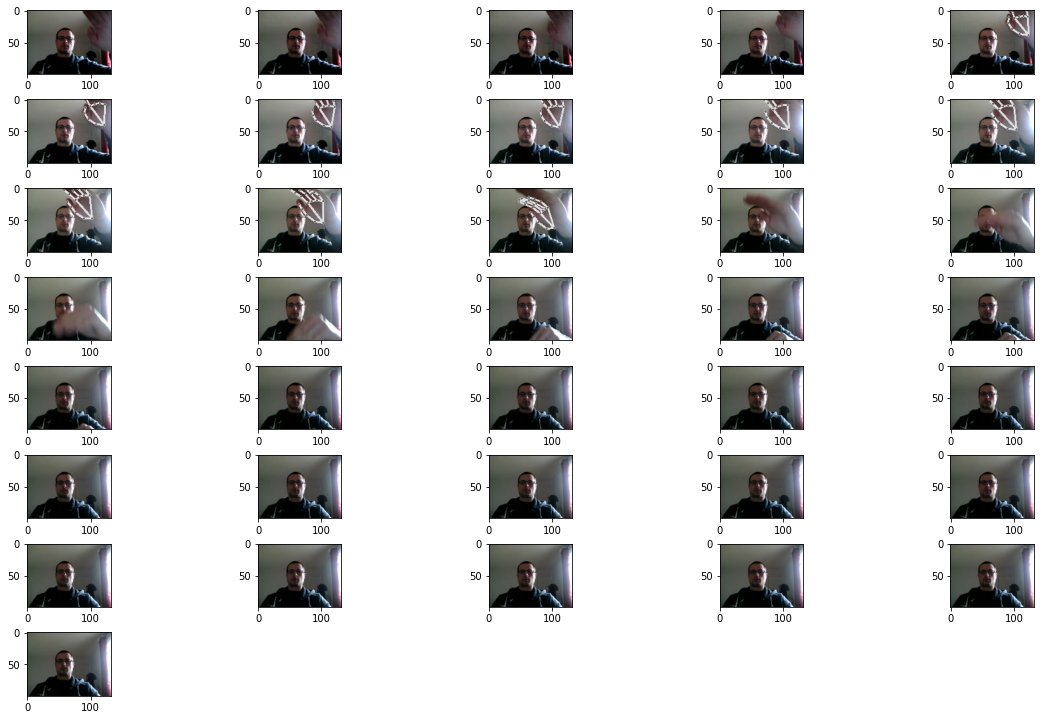

In [ ]:
plot_gesture_incl_keypoints(randint(0, X.shape[0]))

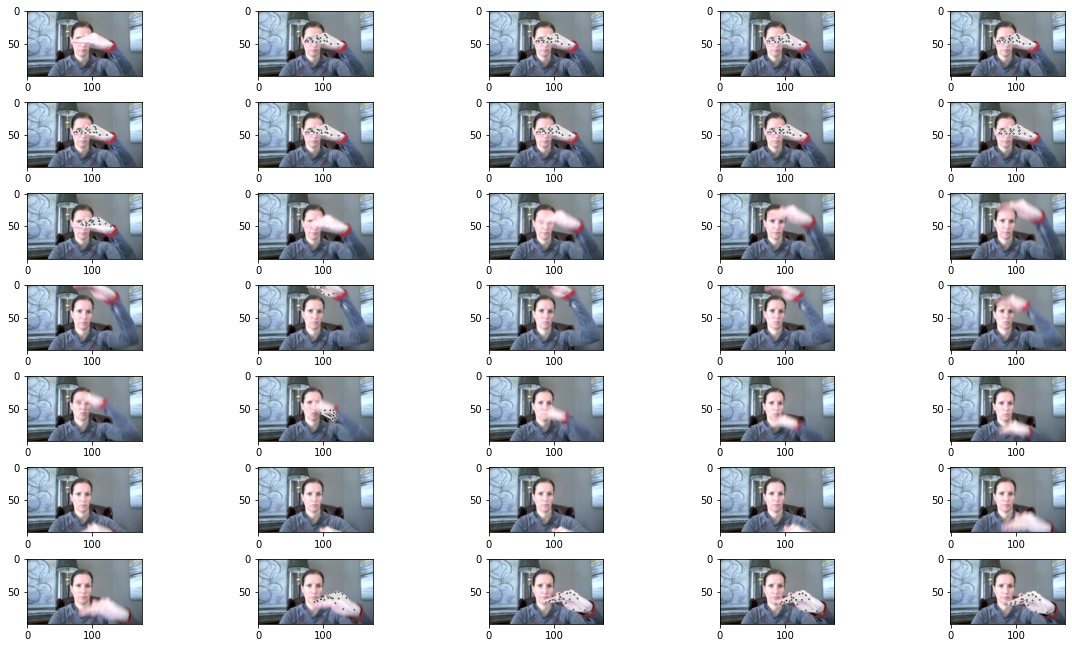

In [ ]:
plot_gesture_incl_keypoints(randint(0, X.shape[0]))

# Feature engineering & data cleaning

In the feature engineering part, we will...

* Remove a gesture not suitable for our use-case
* Remove instances with too many missing keypoints
* Combine classes to generate a variety of new classes
* Cut the sequence length to a more webcam-friendly length

.. with some minor steps in between not worthy to mention here.

#### Load merged data

In [ ]:
X = np.load(os.path.join(keypoints_path , 'X_batches_merged.npy'))
y = np.load(os.path.join(keypoints_path , 'y_batches_merged.npy'))

#### Create helper function needed multiple times in the feature engineering part

In [ ]:
def move_values(data, instance, seq_length, direction = 'back'):
  """
  Move values in each sequence either towards the back of the sequence or towards the front.
  Args:
    data (np.array): Data Array, usually X
    instance (int): index of data array, where this function is applied on
    seq_length (int): Length of sequence
    direction (str): target direction, either 'back' (values move towards the back) or 'front' (values move towarrds the front)
  Returns:
    x (np.array): Instance (instance of data) with values moved towards the intended direction
  """
  #Make sure the instance is not empty
  max_values = data[instance].max(axis = 1)
  if np.array_equal(max_values,np.zeros(seq_length)) == True:
    return np.zeros((seq_length, 63))
  #Else, compute the index of the first keypoints and the last keypoints
  elif np.any(np.not_equal(max_values, np.zeros(seq_length))):
    i_first_value = next(i for i,v in enumerate(max_values) if v != 0)
    i_last_value = next(i for i,v in reversed(list(enumerate(max_values))) if v != 0)

    #create temp datasets which holds the values to be moved and the array of zeros, with which the sequence is padded
    non_zeros = data[instance][i_first_value:i_last_value+1]
    zeros = np.zeros((seq_length - non_zeros.shape[0], 63))

    #Move the values
    if direction == 'back':
      x = np.concatenate((zeros, non_zeros), axis=0)
    elif direction == 'front':
      x = np.concatenate((non_zeros, zeros), axis=0)

  return x

In [ ]:
def calc_zero_share(arr):
  """
  Calculates the shares of zeros (no keypoints extracted) over all instances and all sequence indices
  Args:
    arr (np.array): Data Array, usually X
  Returns:
    zero_share_seq (np.array): Shares of zeros (no keypoints extracted) in each sequence-index, summarized over all instances 
    zero_share_inst (np.array): Shares of zeros (no keypoints extracted) in each instance, summarized over every sequence of this instance 
  """
  
  max_values = np.max(arr, axis = 2)
  zero_share_seq = np.where(max_values != 0, 0, 1).mean(axis = 0).round(3)
  zero_share_inst = np.where(max_values != 0, 0, 1).mean(axis = 1).round(3)

  return zero_share_seq, zero_share_inst

#### Remove "Doing other things", since the expressions within the class are too different from eachother

Other than every other class, the actors of "doing other things" do not perform the same gesture. This makes it unusable for our use-case and thus gets removed.

In [ ]:
X = X[y != 1]
y = y[y != 1]

y = np.where(y != 0, y - 1, y)

#### Move the keypoint values towards the end of each sequence, since this can be handled better by the LSTM cells

In [ ]:
#Loop over all instances in X and apply "move_values"-function
for i in range(len(X)):
  X[i] = move_values(X, i, seq_length = X.shape[1], direction = 'back')

#### Remove all-zeros-sequences 

After moving all values towards the back of the sequences, we will have some sequences at the front only containing zeros. This gets removed.

In [ ]:
print(f'Number of maximum frames in sequence, before: {X.shape[1]}')

#Remove sequences only filled with zeros
zero_share_seq, _ = calc_zero_share(X)
index_first_nonzero = next(i for i,v in enumerate(zero_share_seq) if float(v) != 1.0)
X = X[:, index_first_nonzero:, :]

print(f'\nNumber of maximum frames in sequence, after: {X.shape[1]}')

Number of maximum frames in sequence, before: 67

Number of maximum frames in sequence, after: 39


#### Remove instances with too many missing keypoints

Instances with only a few keypoints can not be interpreted properly by the model. However, the model should also learn to handle some missing values, since mediapipes-Extraction-Model is not perfect. Thus, we will choose the treshhold very carefully.

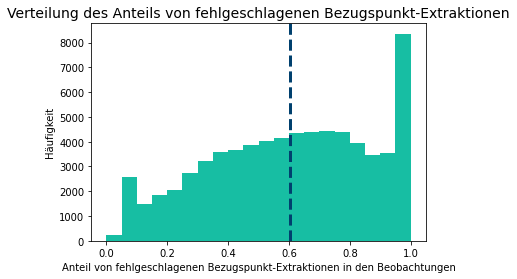

In [ ]:
#Visualize the distribution of missing keypoints as histogram

_, zero_share_inst = calc_zero_share(X[y!=0])

plt.hist(zero_share_inst, bins = 20, color='#17BEA3')
plt.axvline(np.mean(zero_share_inst), color='#00406E', linestyle='dashed', linewidth=3)

plt.ylabel('Häufigkeit')
plt.xlabel('Anteil von fehlgeschlagenen Bezugspunkt-Extraktionen in den Beobachtungen')
plt.title('Verteilung des Anteils von fehlgeschlagenen Bezugspunkt-Extraktionen', fontsize = 14)
plt.show()

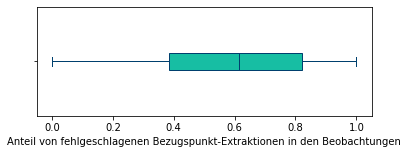


Quantiles: [0.385 0.615 0.821]


In [ ]:
#Visualize the distribution of missing keypoints as boxplot
plt.figure(figsize=(6,2))
bp = plt.boxplot(zero_share_inst, patch_artist=True, vert=False)

for element in ['boxes', 'whiskers', 'fliers', 'means', 'medians', 'caps']:
  plt.setp(bp[element], color='#00406E')

for patch in bp['boxes']:
   patch.set(facecolor='#17BEA3')   

plt.ylabel('')
plt.xlabel('Anteil von fehlgeschlagenen Bezugspunkt-Extraktionen in den Beobachtungen')
plt.yticks([1], [''])
#plt.title('Verteilung des Anteils von fehlgeschlagenen Bezugspunkt-Extraktionen', fontsize = 14)
plt.show()

#Calculate Quantiles and print them
print(f'\nQuantiles: {np.percentile(zero_share_inst, [25, 50, 75])}')

In [ ]:
_, zero_share_inst = calc_zero_share(X)

# Remove any instance where zero_share_inst is lower than the threshold
threshold_share_zeros = 0.821 
X = X[np.logical_or(zero_share_inst < threshold_share_zeros, y==0)]
y = y[np.logical_or(zero_share_inst < threshold_share_zeros, y==0)]

In [ ]:
#Check size of new dataset

from sys import getsizeof

print(f'Size of X in MB: {getsizeof(X)/ 10**6}')

Size of X in MB: 886.977136


#### Combine classes to enlarge the variety of tasks given to the Few-Shot Algorithm

Few Shot Learning Algorithms tend to generalize better, the more classes they see during training. To enlarge the number of classes, we will combine each class with all other classes in order to get 676 new out of the existing 26 classes.

In [ ]:
unique, counts = np.unique(y, return_counts=True)
print(tabulate(np.asarray((unique, counts))))

print(f'\nThe dataset has {str(len(unique))} unique classes.')

----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ---  ----  ----  ----  ----  ----  ----  ----  ----  ----
   0     1     2     3     4     5     6     7     8     9    10    11    12    13    14    15   16    17    18    19    20    21    22    23    24    25
2913  2100  1424  1247  2113  1299  1487  1568  2283  1270  1272  1095  1847  2589  1258  1118  965  1429  1725  1290  1659  1760  2408  2312  2406  2288
----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ---  ----  ----  ----  ----  ----  ----  ----  ----  ----

The dataset has 26 unique classes.


Set up function.

In [ ]:
def combine_classes(X, y):
  """
  Enlarges the variety of the dataset by combining every class with every other class for 250 samples 
  Args:
    X (np.array): data keypoints
    y (np.array): data classes
  Returns:
    comb_X (np.array): combined data keypoints
    comb_y (np.array): combined data labels
    comb_og_y (list): list of data labels with the original labels 
  """

  # create placeholders
  comb_X = []
  comb_y = []
  comb_og_y = []

  #Set number instances to be sampled from each class
  num_samples_per_comb = 250 #250 is the maximum the RAM can handle
  comb_num_instances = len(np.unique(y))*len(np.unique(y)) * num_samples_per_comb

  combinations = []

  y_index = 0

  #create new classes by combining old classes
  for i in range(len(np.unique(y))):
    for ii in range(len(np.unique(y))):
      combinations.append([i, ii])

  #Loop over new class combinations
  for comb in combinations:
    #draw sample for new class from old class 1 and old class 2
    data_start = X[y == comb[0]]
    data_end = X[y == comb[1]]
    start_sample = data_start[np.random.choice(data_start.shape[0], num_samples_per_comb, replace=False), :, :]
    end_sample = data_end[np.random.choice(data_end.shape[0], num_samples_per_comb, replace=False), :, :]

    #Move values of the second part of the combination (old class num 2) towards the front
    for i in range(len(end_sample)):
      end_sample[i] = move_values(end_sample, i, seq_length = end_sample.shape[1], direction = 'front')
    
    #Merge samples of old classes to create a sample for the new class
    sample = np.concatenate((start_sample, end_sample), axis = 1)
    comb_X.append(sample)
    comb_y.append([y_index]*num_samples_per_comb)
    comb_og_y.append([comb[0],comb[1]])
    y_index += 1

  #bring new array comb_X and comb_y into the right shape
  comb_X = np.array(comb_X).reshape(comb_num_instances, np.array(comb_X).shape[2], np.array(comb_X).shape[3])
  comb_y = np.array(comb_y).reshape(comb_X.shape[0])

return comb_X, comb_y, comb_og_y

Apply function.

In [ ]:
X, y, comb_og_y = combine_classes(X, y)

In [ ]:
#print new number of classes
unique, counts = np.unique(y, return_counts=True)
print(f'The dataset has {str(len(unique))} unique classes.')

The dataset has 676 unique classes.


#### Adjust the keypoints in the second part of the sequence, so that it matches the first part

By combining the classes, we merged together two completely independent instances for each new instance. This may result in a jumping hand at the point of transition from the old instance 1 to the old instance 2. We fix this by letting the second half of the new instance (old instance 2) start from the point where the first half of the new instance (old instance 1) ended. The palm of the hand is selected as the reference point.

Set up function.

In [ ]:
def adjust_distance(x, seq_mid, x_indices, y_indices, z_indices):
  """
  Moves the second half of an instance to match the first half and thereby create a fluid hand movement.
  Args:
    x (np.array): instance the function is applied on
    seq_mid (int): index of the sequence-midpoint
    x_indices (list): indices of x keypoints in dimension two of X
    y_indices (list): indices of y keypoints in dimension two of X
    z_indices (list): indices of z keypoints in dimension two of X
  Returns:
    x (np.array): Adjusted instance
  """
  #Calculate distance between the two hands at the transition of the first and second half
  x_distance = x[seq_mid+1, 0] - x[seq_mid, 0] 
  y_distance = x[seq_mid+1, 1] - x[seq_mid, 1] 
  z_distance = x[seq_mid+1, 2] - x[seq_mid, 2] 

  #Calculate last index with keypoints != 0 
  means = x.mean(axis = 0)
  if means.mean() != 0:
    last_zero = next(i for i,v in reversed(list(enumerate(means))) if v != 0)

    #Adjust the second half (until keypoints = 0) of the instance by the calculated distance
    x[seq_mid+1:last_zero +1, x_indices] = x[seq_mid+1:last_zero +1, x_indices] - x_distance
    x[seq_mid+1:last_zero +1 , y_indices] = x[seq_mid+1:last_zero +1, y_indices] - y_distance
    x[seq_mid+1:last_zero +1, z_indices] = x[seq_mid+1:last_zero +1, z_indices] - z_distance

  return x

Apply function.

In [ ]:
#Config indices for x, y and z points in dimension 2 of X
seq_mid = int(X.shape[1] / 2) -1
x_indices = (0, 3, 6, 9, 12, 15, 18, 21, 24, 27, 30, 33, 36, 39, 42, 45, 48, 51, 54, 57, 60)
y_indices = (1, 4, 7, 10, 13, 16, 19, 22, 25, 28, 31, 34, 37, 40, 43, 46, 49, 52, 55, 58, 61)
z_indices = (2, 5, 8, 11, 14, 17, 20, 23, 26, 29, 32, 35, 38, 41, 44, 47, 50, 53, 56, 59, 62)

#Run adjust distance on every instance of X
for i, x in enumerate(X):
  X[i] = adjust_distance(x, seq_mid, x_indices, y_indices, z_indices)

#### Move keypoint values towards the end of the sequence once again

In [ ]:
zero_share_seq, zero_share_inst = calc_zero_share(X)
zero_share_seq

array([0.998, 0.989, 0.921, 0.882, 0.859, 0.837, 0.81 , 0.785, 0.763,
       0.741, 0.713, 0.679, 0.644, 0.605, 0.565, 0.534, 0.496, 0.464,
       0.433, 0.402, 0.372, 0.341, 0.315, 0.287, 0.263, 0.243, 0.223,
       0.202, 0.198, 0.192, 0.185, 0.176, 0.161, 0.152, 0.142, 0.138,
       0.134, 0.125, 0.034, 0.003, 0.001, 0.001, 0.001, 0.001, 0.001,
       0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001,
       0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001,
       0.555, 0.594, 0.631, 0.671, 0.706, 0.736, 0.76 , 0.782, 0.81 ,
       0.837, 0.859, 0.881, 0.921, 0.989, 0.998])

In [ ]:
#Run move values on every instance of X
for i in range(len(X)):
  X[i] = move_values(X, i, seq_length = X.shape[1], direction = 'back')

In [ ]:
zero_share_seq, zero_share_inst = calc_zero_share(X)
zero_share_seq

array([1.   , 1.   , 1.   , 0.998, 0.993, 0.987, 0.981, 0.975, 0.967,
       0.959, 0.95 , 0.941, 0.931, 0.918, 0.903, 0.886, 0.864, 0.815,
       0.781, 0.754, 0.728, 0.699, 0.671, 0.645, 0.617, 0.587, 0.554,
       0.522, 0.488, 0.454, 0.426, 0.397, 0.371, 0.345, 0.32 , 0.297,
       0.274, 0.254, 0.233, 0.215, 0.195, 0.175, 0.158, 0.15 , 0.141,
       0.131, 0.121, 0.109, 0.099, 0.088, 0.081, 0.073, 0.062, 0.017,
       0.002, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001,
       0.001, 0.003, 0.012, 0.02 , 0.026, 0.031, 0.035, 0.04 , 0.042,
       0.045, 0.047, 0.049, 0.052, 0.049, 0.001])

#### Cut sequence length to a more compatible length.

In [ ]:
print(f'Current length of every input sequence: {X.shape[1]}')

Current length of every input sequence: 78


We reduce the sequence length to 72 because this number is easily dividable by both 12 (the frame rate of the data set) and 24 (a common frame rate for a smooth video stream). The loss of information is barely noticeable.

In [ ]:
X = X[:, 6:, :]
print(f'New length of every input sequence: {X.shape[1]}')

New length of every input sequence: 72


#### Upload X & y to GDrive

X and y are the data basis for all steps in modeling.

In [ ]:
np.save(os.path.join(target_path, 'X.npy'), X)
np.save(os.path.join(target_path, 'y.npy'), y)
np.save(os.path.join(target_path, 'y_og.npy'), comb_og_y)

# Data analysis #3 - past feature engineering & cleaning

In [ ]:
X = np.load(os.path.join(target_path, 'X.npy'), X)
y = np.load(os.path.join(target_path, 'y.npy'), y)
y_og = np.load(os.path.join(target_path, 'y_og.npy'), comb_og_y)

#### Analyse classes in the dataset and their number of representations.

In [ ]:
unique, counts = np.unique(y, return_counts=True)
print(tabulate(np.asarray((unique, counts))))

print(f'\n The dataset has {str(len(unique))} unique classes.')

---  ---  ---  ---  ---  ---  ---  ---  ---  ---  ---  ---  ---  ---  ---  ---  ---  ---  ---  ---  ---  ---  ---  ---  ---  ---  ---  ---  ---  ---  ---  ---  ---  ---  ---  ---  ---  ---  ---  ---  ---  ---  ---  ---  ---  ---  ---  ---  ---  ---  ---  ---  ---  ---  ---  ---  ---  ---  ---  ---  ---  ---  ---  ---  ---  ---  ---  ---  ---  ---  ---  ---  ---  ---  ---  ---  ---  ---  ---  ---  ---  ---  ---  ---  ---  ---  ---  ---  ---  ---  ---  ---  ---  ---  ---  ---  ---  ---  ---  ---  ---  ---  ---  ---  ---  ---  ---  ---  ---  ---  ---  ---  ---  ---  ---  ---  ---  ---  ---  ---  ---  ---  ---  ---  ---  ---  ---  ---  ---  ---  ---  ---  ---  ---  ---  ---  ---  ---  ---  ---  ---  ---  ---  ---  ---  ---  ---  ---  ---  ---  ---  ---  ---  ---  ---  ---  ---  ---  ---  ---  ---  ---  ---  ---  ---  ---  ---  ---  ---  ---  ---  ---  ---  ---  ---  ---  ---  ---  ---  ---  ---  ---  ---  ---  ---  ---  ---  ---  ---  ---  ---  ---  ---  ---  ---  ---  ---  ---  ---  ---  

#### Plot the length of gestures performed, measured in frames

In [ ]:
#Loop over all keypoint-instances, find the index of the first and last keypoint and form the distance between both indexes
gesture_length = []
for i in range(len(X)):
  means = X[i].mean(axis = 1)
  if means.max() != 0:
    start_frame = next(i for i,v in enumerate(means) if v != 0)
    end_frame = next(i for i,v in reversed(list(enumerate(means))) if v != 0)
    gesture_length.append(end_frame - start_frame)
  else: 
    gesture_length.append(end_frame - start_frame)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


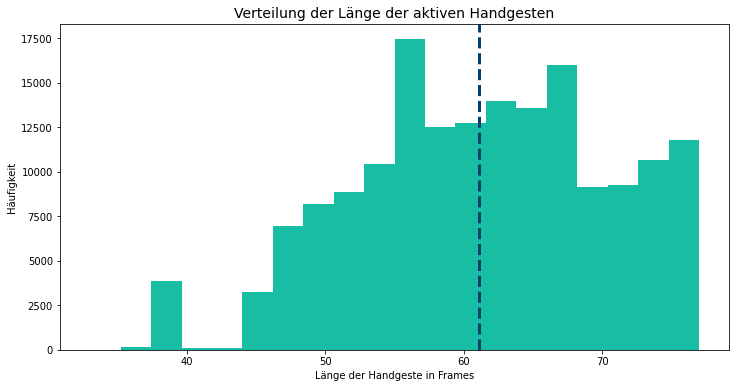

Average: 61.129479289940825


In [ ]:
# Visualize length of active gestures as histogram
plt.figure(figsize=(12,6))

plt.hist(x = gesture_length, color = '#17BEA3', bins = 20)
plt.axvline(np.mean(gesture_length), color='#00406E', linestyle='dashed', linewidth=3)

axes = plt.axes()
plt.ylabel('Häufigkeit')
plt.xlabel('Länge der Handgeste in Frames')
plt.title('Verteilung der Länge der aktiven Handgesten', fontsize = 14)
plt.show()

print(f'Average: {np.mean(gesture_length)}')

#### Plot the share of frames in an instance, where mediapipe could not extract keypoints

In [ ]:
#Calculate the share of frames in an instance where mediapipe could not extract keypoints
max_values = np.max(X, axis = 2)

zero_share_seq = np.where(max_values != 0, 0, 1).mean(axis = 0).round(3)
zero_share_inst = np.where(max_values != 0, 0, 1).mean(axis = 1).round(3)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


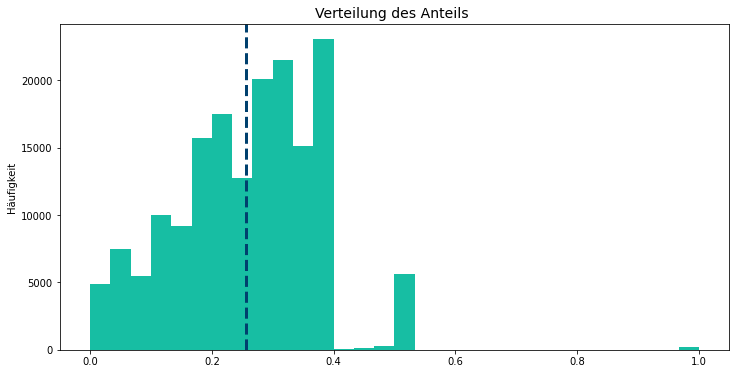

Average: 0.2560378402366864


In [ ]:
#Visualize as histogram
plt.figure(figsize=(12,6))

plt.hist(x = zero_share_inst, color = '#17BEA3', bins = 30 )
plt.axvline(np.mean(zero_share_inst), color='#00406E', linestyle='dashed', linewidth=3)

axes = plt.axes()
plt.ylabel('Häufigkeit')
plt.xlabel('')
plt.title('Verteilung des Anteils ', fontsize = 14)
plt.show()

print(f'Average: {np.mean(zero_share_inst)}')